In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
from nibabel.testing import data_path

## Getting filepaths

In [4]:
# psea12_bl = np.sort(np.array(os.listdir('data/new/PSEA12 Baseline')))[1:]
# psea12_bl = np.array(['data/new/PSEA12 Baseline/' + file for file in psea12_bl])
# psea12_bl_imgs = psea12_bl[['Mask' not in name for name in psea12_bl]]
# psea12_bl_masks = psea12_bl[['Mask' in name for name in psea12_bl]]

FileNotFoundError: [Errno 2] No such file or directory: 'data/new/PSEA12 Baseline'

In [6]:
psea12_pg = np.sort(np.array(os.listdir('data/new/PSEA12 PostGel')))[1:]
psea12_pg = np.array(['data/new/PSEA12 PostGel/' + file for file in psea12_pg])
psea12_pg_imgs = psea12_pg[['Mask' not in name for name in psea12_pg]]
psea12_pg_masks = psea12_pg[['Mask' in name for name in psea12_pg]]

In [7]:
psea12_pmi = np.sort(np.array(os.listdir('data/new/PSEA12 PostMI')))[1:]
psea12_pmi = np.array(['data/new/PSEA12 PostMI/' + file for file in psea12_pmi])
psea12_pmi_imgs = psea12_pmi[['Mask' not in name for name in psea12_pmi]]
psea12_pmi_masks = psea12_pmi[['Mask' in name for name in psea12_pmi]]

## Create input image files/masks

In [8]:
input_img_file = 'models/UNet2d/lv_input_imgs'
input_masks_file = 'models/UNet2d/lv_input_masks'

with open(input_img_file, 'w') as f:
    for file in np.concatenate([psea12_bl_imgs, psea12_pg_imgs, psea12_pmi_imgs]):
        f.write('../../' + file + '\n')
        
with open(input_masks_file, 'w') as f:
    for file in np.concatenate([psea12_bl_masks, psea12_pg_masks, psea12_pmi_masks]):
        f.write('../../' + file + '\n')

FileNotFoundError: [Errno 2] No such file or directory: 'models/UNet2d/lv_input_imgs'

Images are 300 x 300 x 37

In [9]:
def show_image(filepath, depth):
    image = nib.load(filepath)
    plt.imshow(image.get_fdata()[:,:,depth])

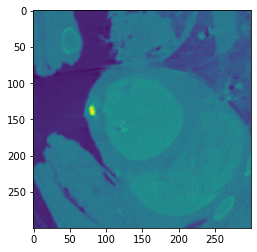

In [11]:
show_image(psea12_pg_imgs[0], 20)

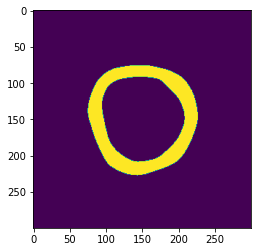

In [12]:
show_image(psea12_pg_masks[0], 20)

In [13]:
nib.load(psea12_pg_masks[0]).get_fdata().max()

1.0

In [19]:
## import monai
from monai.transforms import(
    Compose,
    LoadNiftid,
    AddChanneld,
    ScaleIntensityRangePercentilesd,
    RandCropByPosNegLabeld,
    CenterSpatialCropd,
    ToTensord
)

data_keys = ["image", "mask"]
data_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        ScaleIntensityRangePercentilesd(
            keys='image',
            lower=25,
            upper=75,
            b_min=-0.5,
            b_max=0.5
        )
    ]
)

train_dataset = monai.data.CacheDataset(
    data=[{'image': psea12_pg_imgs[0], 'mask': psea12_pg_masks[0]}],
    transform=Compose(
        [
            data_transforms,
            RandCropByPosNegLabeld(
                keys=data_keys,
                label_key="mask",
                spatial_size=[256, 256, 16],
                num_samples=4,
                image_key="image",
                pos=0.8,
                neg=0.2
            ),
            ToTensord(keys=data_keys)
        ]
    ),
    cache_rate=1.0
)

Load and cache transformed data: 100%|██████████| 1/1 [00:00<00:00, 2423.05it/s]
